In [2]:
import numpy as np
import tensorflow as tf

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.client import device_lib
print([dev.name for dev in device_lib.list_local_devices()])

['/device:CPU:0', '/device:GPU:0']


2024-01-23 15:48:27.811908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 15:48:27.812167: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 15:48:27.812308: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 15:48:27.812639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 15:48:27.812666: I tensorflow/core/common_runtime/gpu/gpu

# Load dataset

In [3]:
def decode(tensor):
    """
    Converts the 12 uint64s into a 768 float32 tensor.
    """
    masks = tf.convert_to_tensor(2 ** np.arange(64, dtype=np.int64))
    masked = tf.bitwise.bitwise_and(tf.expand_dims(tensor, -1), masks)
    expanded = tf.cast(tf.not_equal(masked, 0), dtype=tf.float32)
    return tf.reshape(expanded, (-1, 768))

# read file
dataset = tf.data.Dataset.list_files('../data/dataset/*.bin')
dataset = tf.data.FixedLengthRecordDataset(dataset, record_bytes=3 * 12 * 8)
dataset = dataset.map(lambda s: tf.reshape(tf.io.decode_raw(s, tf.int64), (3, 12)))
# dataset = dataset.take(2)
dataset = dataset.batch(4096)
#dataset = dataset.map(decode)

2024-01-23 15:48:31.155557: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 15:48:31.155751: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 15:48:31.155807: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 15:48:31.156219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 15:48:31.156327: I external/local_xla/xla/stream_executor

In [4]:
batch = next(iter(dataset.take(1)))
batch.shape

TensorShape([4096, 3, 12])

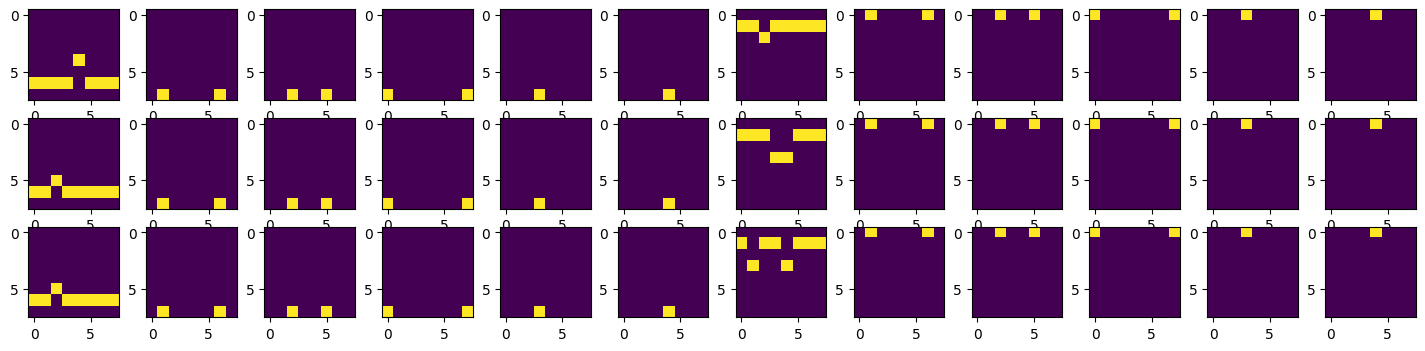

In [6]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(3, 12, figsize=(18, 4))
for kind in range(3):
    for layer in range(12):
        axs[kind][layer].imshow(decode(batch.numpy()[0]).numpy()[kind].reshape((12,8,8))[layer])
plt.show()

# Train

In [7]:
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Concatenate, Lambda
from keras.optimizers import SGD

In [40]:
def custom_loss(_y_true, y_pred):
    """
    Compute loss as defined in https://erikbern.com/2014/11/29/deep-learning-for-chess.html
    // sum(p,q,r)logS(f(q)−f(r))+K*log(f(p)+f(q))+K*log(−f(q)−f(p))
    """
    p = y_pred[0]
    q = y_pred[1]
    r = y_pred[2]
    K = 10.0

    a = - tf.math.log(tf.math.sigmoid(q - r))
    b = - K * tf.math.log(tf.math.sigmoid(p + q))
    c = - K * tf.math.log(tf.math.sigmoid(-q - p))

    return a + b + c

def make_chess_model():
    inp = tf.keras.Input(shape=(12,), dtype=tf.int64)
    x = decode(inp) # convert 12 ints to 768 floats
    x = Dense(2048, activation="relu")(x)
    x = Dense(2048, activation="relu")(x)
    x = Dense(2048, activation="relu")(x)
    x = Dense(1)(x)
    return Model(inp, x)

def make_siamese_model(chess_model):
    boards = tf.keras.Input(shape=(3, 12), dtype=tf.int64)

    p_board = boards[:, 0, :]
    q_board = boards[:, 1, :]
    r_board = boards[:, 2, :]

    p = chess_model(p_board)
    q = chess_model(q_board)
    r = chess_model(r_board)

    model = Model(
        inputs=[boards],
        outputs=[p, q, r]
    )
    model.compile('adam', loss=custom_loss, metrics=[])
    return model

chess_model = make_chess_model()
train_model = make_siamese_model(chess_model)
chess_model.summary()
train_model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 12)]              0         
                                                                 
 tf.expand_dims_12 (TFOpLam  (None, 12, 1)             0         
 bda)                                                            
                                                                 
 tf.bitwise.bitwise_and_12   (None, 12, 64)            0         
 (TFOpLambda)                                                    
                                                                 
 tf.math.not_equal_12 (TFOp  (None, 12, 64)            0         
 Lambda)                                                         
                                                                 
 tf.cast_12 (TFOpLambda)     (None, 12, 64)            0         
                                                          

In [34]:
chess_model(batch[0])

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.13650724],
       [0.12047085],
       [0.11492033]], dtype=float32)>

In [35]:
train_model.predict(batch)

128/128 [==============================] - 1s 5ms/step


[array([[0.13650723],
        [0.01309171],
        [0.05350399],
        ...,
        [0.1338489 ],
        [0.04396537],
        [0.10186657]], dtype=float32),
 array([[0.12047089],
        [0.09634117],
        [0.04116507],
        ...,
        [0.1446475 ],
        [0.08069891],
        [0.06396127]], dtype=float32),
 array([[0.11492033],
        [0.09494121],
        [0.06105151],
        ...,
        [0.13308671],
        [0.06717613],
        [0.07955478]], dtype=float32)]

In [43]:
history = train_model.fit(
    dataset.map(lambda x : (x, tf.constant([0.0]))),
    epochs=5
)

Epoch 1/5
738/738 [==============================] - 100s 136ms/step - loss: 43.6742 - model_24_loss: 14.5574 - model_24_1_loss: 14.5583 - model_24_2_loss: 14.5584
Epoch 2/5


2024-01-23 16:12:20.707885: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11179685076252936827


264/738 [=========>....................] - ETA: 1:07 - loss: 43.6663 - model_24_loss: 14.5563 - model_24_1_loss: 14.5548 - model_24_2_loss: 14.5551